## Bird species classification

**First of all, we import usefull libraries**

In [18]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F #To get the cross entropy loss function, as well as the softmax function to get a probability output
import matplotlib.pyplot as plt
import torchvision.transforms as T #To resize images, convert PIL images into Pytorch tensors
import torchvision.models as models #To get the pretrained neural networks
from torch.utils.data import DataLoader #To segment our datasets into shuffled batches for the training
from torchvision.utils import make_grid  #To plot a few images of our dataset
from sklearn.metrics import confusion_matrix #To evaluate the performance of our model
import itertools
import numpy as np

**We get and preprocess our data**

In [21]:
train_path = r"C:/Users/thete/OneDrive/Documents/ProjetS3/trainaugm" #insert your path here
valid_path = r"C:/Users/thete/OneDrive/Documents/ProjetS3/valid" #insert your path here


In [22]:
test_path = r"C:/Users/thete/OneDrive/Documents/ProjetS3/test" #insert your path here

In [23]:
transform_dataset = T.Compose([
    T.Resize((128,128)),
    T.RandomHorizontalFlip(),
    T.ToTensor()
])

train_dataset = torchvision.datasets.ImageFolder(root=train_path , transform=transform_dataset)
valid_dataset = torchvision.datasets.ImageFolder(root=valid_path , transform=transform_dataset)
test_dataset = torchvision.datasets.ImageFolder(root=test_path , transform=transform_dataset)

In [24]:
number_of_species = len(train_dataset.classes)
print("Birds will be classified among" , number_of_species , "bird species")

Les oiseaux seront classifiés parmis 5 espèces d'oiseaux.


In [25]:
batch_size = 32 #preferably of power of 2

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=False)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=False)


**We plot a few image of our dataset**

In [26]:
def show_images(train_dl):
    for images, labels in train_dl:
        fig, ax = plt.subplots(figsize=(10,10))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:32], nrow=8).permute(1,2,0))
        break

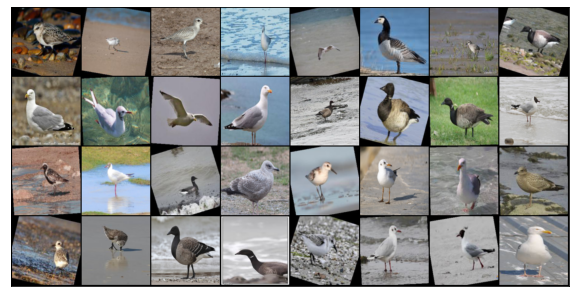

In [27]:
bird_images = show_images(train_dataloader)
bird_images

**Define the GPU as our default device, CPU if GPU is missing**

In [28]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")
    
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device
        
    def __iter__(self):
        for x in self.dataloader:
            yield to_device(x, self.device)
            
    def __len__(self):
        return len(self.dataloader)

In [29]:
device = get_device()
device

device(type='cuda')

In [30]:
train_dataloader = DeviceDataLoader(train_dataloader, device)
valid_dataloader = DeviceDataLoader(valid_dataloader, device)

**Defining our model**

In [31]:
#Fonction calculant la précision, la métrique choisie par l'équipe, elle sera utilisée dans l'entraînement pour calculer la précision à chaque epoch

def accuracy(out, labels):
    _, preds = torch.max(out, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [32]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {"valid_loss": loss.detach(), "valid_acc": acc}
    
    def validation_epoch_end(self, outputs):
        batch_loss = [x["valid_loss"] for x in outputs]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_acc = [x["valid_acc"] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {"valid_loss": epoch_loss.item(), "valid_acc": epoch_acc.item()}
    
    def epoch_end(self, epoch, epochs, result):
        print("Epoch: [{}/{}], last_lr: {:.6f}, train_loss: {:.4f}, valid_loss: {:.4f}, valid_acc: {:.4f}".format(
            epoch+1, epochs, result["lrs"][-1], result["train_loss"], result["valid_loss"], result["valid_acc"]))

In [33]:
class model(ImageClassificationBase):
    def __init__(self, num_classes):
        super().__init__()
        self.network = models.resnet18(pretrained=True)
        number_of_features = self.network.fc.in_features
        self.network.fc = nn.Linear(number_of_features, number_of_species)
        
    def forward(self, xb):
        return self.network(xb)
    
    def freeze(self):
        for param in self.network.parameters():
            param.requires_grad= False
        for param in self.network.fc.parameters():
            param.requires_grad= True
        
    def unfreeze(self):
        for param in self.network.parameters():
            param.requires_grad= True

In [34]:
model = to_device(model(num_classes=number_of_species), device)
model

model(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [35]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
                           nn.BatchNorm2d(out_channels),
                           nn.ReLU())]
    
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)
    
    
class resnet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128,128))
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(8), nn.Flatten(), nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

**Training functions**

In [36]:
@torch.no_grad()
def evaluate(model, valid_dataloader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in valid_dataloader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]
    
def fit_one_cycle(epochs, max_lr, model, train_dataloader, valid_dataloader, weight_decay=0, opt_func=torch.optim.Adam):
    torch.cuda.empty_cache()
    
    history = []
    
    opt = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr, epochs=epochs,
                                               steps_per_epoch=len(train_dataloader))
    
    for epoch in range(epochs):
        model.train()
        train_loss = []
        lrs = []
        for batch in train_dataloader:
            loss = model.training_step(batch)
            train_loss.append(loss)
            loss.backward()
                
            opt.step()
            opt.zero_grad()
            
            lrs.append(get_lr(opt))
            sched.step()
            
        result = evaluate(model, valid_dataloader)
        result["train_loss"] = torch.stack(train_loss).mean().item()
        result["lrs"] = lrs
        model.epoch_end(epoch, epochs, result)
        history.append(result)
    return history

In [37]:
result = [evaluate(model, valid_dataloader)]
result

[{'valid_loss': 1.800991415977478, 'valid_acc': 0.3151041567325592}]

In [38]:
model.freeze()

**Define here some training hyperparameters**

In [39]:
epochs = 55
max_lr = 5*10e-5
weight_decay = 10e-4
opt_func = torch.optim.Adam

In [40]:
%%time

history = fit_one_cycle(epochs, max_lr, model, train_dataloader, valid_dataloader, weight_decay=weight_decay, opt_func=opt_func)

Epoch: [1/55], last_lr: 0.000024, train_loss: 1.7813, valid_loss: 1.7189, valid_acc: 0.2135
Epoch: [2/55], last_lr: 0.000037, train_loss: 1.6815, valid_loss: 1.6301, valid_acc: 0.3099
Epoch: [3/55], last_lr: 0.000058, train_loss: 1.5910, valid_loss: 1.4974, valid_acc: 0.3490
Epoch: [4/55], last_lr: 0.000086, train_loss: 1.4813, valid_loss: 1.3752, valid_acc: 0.4271
Epoch: [5/55], last_lr: 0.000120, train_loss: 1.3502, valid_loss: 1.1954, valid_acc: 0.4688
Epoch: [6/55], last_lr: 0.000160, train_loss: 1.2213, valid_loss: 1.0451, valid_acc: 0.5703
Epoch: [7/55], last_lr: 0.000203, train_loss: 1.1159, valid_loss: 0.9261, valid_acc: 0.6224
Epoch: [8/55], last_lr: 0.000248, train_loss: 1.0058, valid_loss: 0.8213, valid_acc: 0.6849
Epoch: [9/55], last_lr: 0.000294, train_loss: 0.9230, valid_loss: 0.7732, valid_acc: 0.6693
Epoch: [10/55], last_lr: 0.000338, train_loss: 0.8564, valid_loss: 0.7143, valid_acc: 0.7161
Epoch: [11/55], last_lr: 0.000380, train_loss: 0.8135, valid_loss: 0.6338, vali

In [41]:
model.unfreeze()

In [54]:
epochs = 5
max_lr = 10e-5
weight_decay = 10e-4
opt_func = torch.optim.Adamax

In [55]:
%%time

history += fit_one_cycle(epochs, max_lr, model, train_dataloader, valid_dataloader, weight_decay=weight_decay, opt_func=opt_func)


Epoch: [1/5], last_lr: 0.000076, train_loss: 0.0109, valid_loss: 0.3901, valid_acc: 0.8880
Epoch: [2/5], last_lr: 0.000095, train_loss: 0.0066, valid_loss: 0.4326, valid_acc: 0.9010
Epoch: [3/5], last_lr: 0.000061, train_loss: 0.0185, valid_loss: 0.4492, valid_acc: 0.8880
Epoch: [4/5], last_lr: 0.000019, train_loss: 0.0072, valid_loss: 0.4057, valid_acc: 0.8750
Epoch: [5/5], last_lr: 0.000000, train_loss: 0.0061, valid_loss: 0.3715, valid_acc: 0.9036
Wall time: 2min 46s


In [47]:
max_acc = max([history[i]["valid_acc"] for i in range(len(history))])
print("During our training, the maximum accuracy obtained by our model is : " ,
round(max([history[i]["valid_acc"] for i in range(len(history))]) , 3))

Au cours de l'entrainement, la précision maximale atteinte par notre modèle est de 0.909


**Get the predictions of the test dataset**

In [48]:
def prediction(model, images):
    xb = to_device(images.unsqueeze(0), device)
    out = model(xb)
    _, preds = torch.max(out, dim=1)
    predictions = test_dataset.classes[preds[0].item()]
    return predictions

Label:  MouetteRieuse
Prediction:  BecasseauSanderling


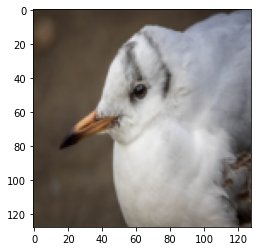

In [56]:
#Exemple of a prediction
indice = 78
images, labels = test_dataset[indice]
print("Label: ", test_dataset.classes[labels])
print("Prediction: ", prediction(model, images))
plt.imshow(images.permute(1,2,0))

In [57]:
predictions = []
labels = []

for i in range(len(test_dataset)):
    images_, labels_ = test_dataset[i]
    predictions.append(prediction(model, images_))
    labels.append(test_dataset.classes[labels_])


num_correct = sum(p == t for p, t in zip(predictions, labels))
print("Our model's accuracy on test dataset is" , round(num_correct/len(predictions),3))

La précision sur le jeu de donnée de test de notre modèle est de 0.847


**Confusion matrix**

In [52]:
class_names= train_dataset.classes

def plot_confusion_matrix(cm, classes, normalize=False, title='confusion matrix', cmap=plt.cm.Blues):
    # This function prints and plots the confusion matrix. Normalization can be applied by setting normalize=True
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("normalized confusion matrix")
    else:
        print('confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('true label')
    plt.xlabel('predicted label')

normalized confusion matrix


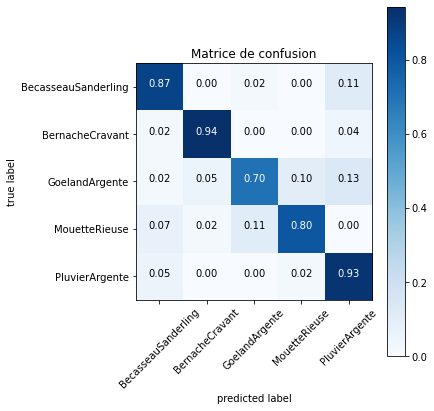

In [58]:
# compute confusion matrix
cnf_matrix = confusion_matrix(labels, predictions)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure(figsize=(6, 6))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Confusion matrix')

plt.show()